# Autodiff

## Regression in PyTorch

In [20]:
import torch 
import matplotlib.pyplot as plt

In [21]:
x = torch.tensor([0,1,2,3,4,5,6,7.])
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

> 🪶 The `.` at the end of the array of numbers signifies that all these numbers are floating point numbers. This is because PyTorch makes it so that if one of the elements is 0 then all the elements are 0

Now, let's simulatea normally distributed dataset with added noise using `torch.normal()` for our y values

In [22]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=1)
y

tensor([ 3.9449,  2.7341,  0.6923,  1.4380,  0.4872,  0.7397, -1.3531, -0.1975])

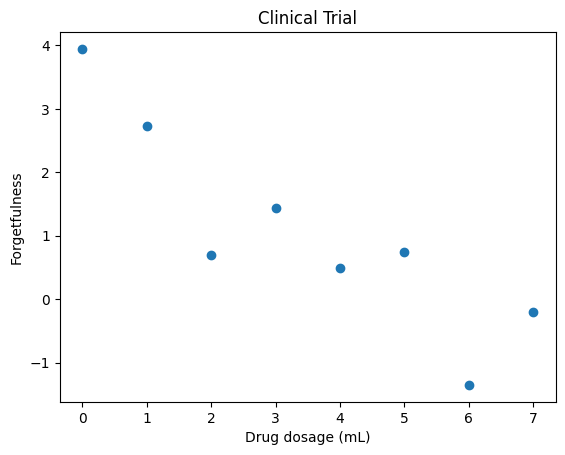

In [23]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Forgetfulness")
_ = ax.scatter(x,y)

**Deliberately** choosing a **slope and a y-intercept** that the model will have to work with and tracking gradients through forward pass with `requires_grad()`

In [24]:
m = torch.tensor([0.9]).requires_grad_()
b = torch.tensor([0.1]).requires_grad_()

m,b

(tensor([0.9000], requires_grad=True), tensor([0.1000], requires_grad=True))

In [25]:
def regression(my_x, my_m, my_b):
    """
    Gives y given x, slope and y-intercept
    """
    return my_m*my_x + my_b

def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b).detach().item()
    y_max = regression(x_max, my_m, my_b).detach().item()
    
    ax.set_xlim([x_min, x_max])
    
    plotx = [x_min, x_max]
    ploty = [y_min, y_max]
    _ = ax.plot(plotx,ploty)

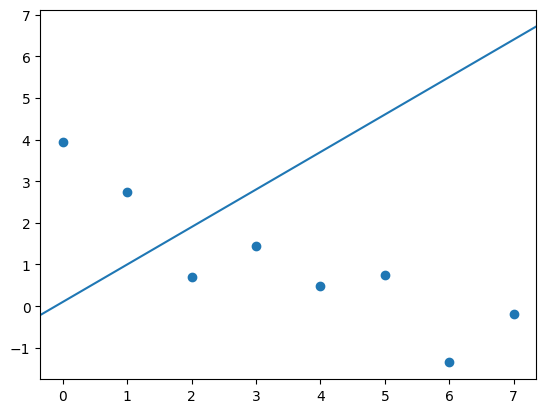

In [26]:
regression_plot(x,y,m,b)
# Plotting our terrible initial points of slope 9 and y-intercept 0.1

## What is a gradient

A gradient is a vector consisting of the partial derivatives of a function with respect to each variable. It points in the direction of the steepest ascent of the function’s value.

### Significance of gradient value:
**Direction**: The way in which you should change your parameters to increase the function’s value the most.

**Magnitude**: How steep the function is at that point; a larger magnitude means a steeper slope.

## Chain Rule's importance

> 🪶 feedforward is the combination of linear transformation and the activation function 
> 
> **Feedforward** $y=\phi(z = weights*inputs + bias)$
> 
> **Slope intercept form** $y = mx + b$

1. We have the feedforward function in the form of $y = mx+b$
2. Compare $\hat{y}$(yPred) with $y$ (yTrue) to calculate cost $C$
$$\hat{y} = f(x,m,b)$$
$$C = g(\hat{y},y)$$
---
$$C = g(f(x,m,b),y)$$
3. Chain rule to calculate gradient of C with respect to parameters
4. Adjust to reduce $C$

### Step 1: Forward Pass

In [27]:
yhat = regression(x, m, b)
yhat

tensor([0.1000, 1.0000, 1.9000, 2.8000, 3.7000, 4.6000, 5.5000, 6.4000],
       grad_fn=<AddBackward0>)

### Step 2: Getting our Loss/Cost

Using MSE again
$$C = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $$

> ❗ Every Output from the functions below are still inputed, displayed and passed as *tensor objects*

In [28]:
def mse(my_yhat, my_y): 
    sigma = torch.sum((my_yhat - my_y)**2)
    return sigma/len(my_y)


In [29]:

C = mse(yhat,y)
C

tensor(17.1025, grad_fn=<DivBackward0>)

### Step 3: Autodiff to calculate gradient of C w.r.t. parameters

Substep 1: Using `.backward()` to calculate the partial derivatives with respect to each parameter in the model. It stores each gradient

In [30]:
C.backward()
C

tensor(17.1025, grad_fn=<DivBackward0>)

In [31]:
#gradient descent of slope and y-intercept
m.grad, b.grad

(tensor([31.0553]), tensor([4.3786]))

### Step 4: Gradient Descent

In [32]:
# initializing our optimizer, now that we have gradient values for m, and b, it's time to do optimization via gradient descent.
optimizer = torch.optim.SGD([m,b], lr=0.01)

In [33]:
# with a learning rate of 0.01, we just adjusted the values of m and b
optimizer.step()
m,b

(tensor([0.5894], requires_grad=True), tensor([0.0562], requires_grad=True))

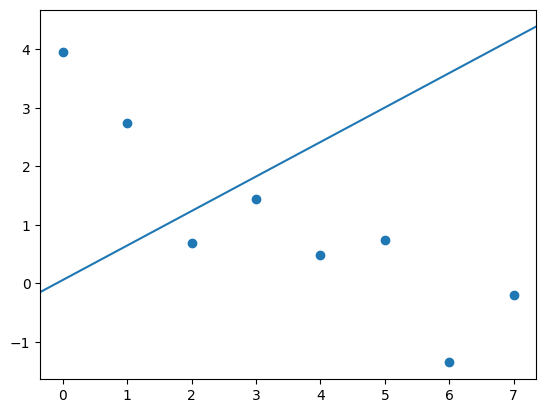

In [34]:
regression_plot(x,y,m,b) #new plot with new values of m and b

Compared to the last plot, our line was much steaper and we reduced the max y of our line from sub 6 to sub 4

Now we repeat steps 1 and 2 to confirm if the cost has decreased:

In [35]:

yhat = regression(x, m, b)
C = mse(yhat,y)
C

tensor(9.0513, grad_fn=<DivBackward0>)

In [36]:
epochs = 1000
# 1000 rounds of training
for epoch in range(epochs):
    optimizer.zero_grad() #resets the gradients to 0 so they don't accumulate
    
    yhat = regression(x, m, b) #step 1
    C = mse(yhat,y) #step 2
    
    C.backward()# steps 3 
    optimizer.step()# step 4
    
    print(f"Epoch {epoch}, cost {C.item():.3g}, m grad{m.grad.item():.3g}, b grad{b.grad.item():.3g}")

Epoch 0, cost 9.05, m grad19.9, b grad2.12
Epoch 1, cost 5.78, m grad12.8, b grad0.683
Epoch 2, cost 4.43, m grad8.25, b grad-0.225
Epoch 3, cost 3.87, m grad5.38, b grad-0.798
Epoch 4, cost 3.62, m grad3.55, b grad-1.16
Epoch 5, cost 3.5, m grad2.39, b grad-1.38
Epoch 6, cost 3.43, m grad1.65, b grad-1.52
Epoch 7, cost 3.38, m grad1.18, b grad-1.61
Epoch 8, cost 3.34, m grad0.88, b grad-1.66
Epoch 9, cost 3.31, m grad0.688, b grad-1.69
Epoch 10, cost 3.28, m grad0.565, b grad-1.7
Epoch 11, cost 3.25, m grad0.487, b grad-1.71
Epoch 12, cost 3.21, m grad0.436, b grad-1.71
Epoch 13, cost 3.18, m grad0.403, b grad-1.7
Epoch 14, cost 3.15, m grad0.381, b grad-1.7
Epoch 15, cost 3.12, m grad0.367, b grad-1.69
Epoch 16, cost 3.09, m grad0.357, b grad-1.68
Epoch 17, cost 3.06, m grad0.35, b grad-1.67
Epoch 18, cost 3.03, m grad0.344, b grad-1.66
Epoch 19, cost 3, m grad0.34, b grad-1.66
Epoch 20, cost 2.98, m grad0.337, b grad-1.65
Epoch 21, cost 2.95, m grad0.334, b grad-1.64
Epoch 22, cost 

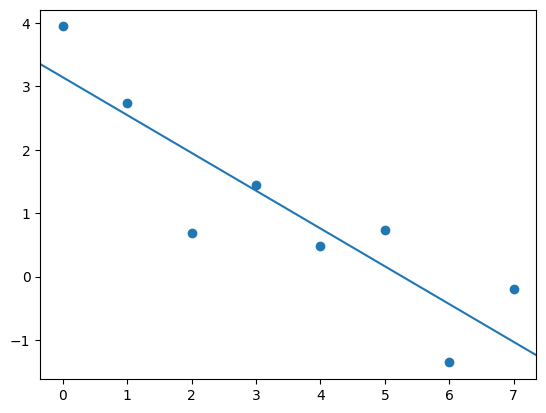

In [37]:
regression_plot(x,y,m,b)